# Transient Heat Conduction
Heat conduction is used in many applications to analyze how to keep things like computer chips and engines cool. 

### The heat diffusion equation:
The most important equation in heat conduction is the heat diffusion equation. This describes the heat conduction through an object with any geometry in cartesian coordinates.
$$ \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right) + \frac{\partial}{\partial z} \left( k \frac{\partial T}{\partial z} \right) + \dot{q} = \rho c_{p}\frac{\partial T}{\partial t} $$

The first three terms just represent the temperature gradients through each direction, the $\dot{q}$ term represents the internal energy generation. This would be if there is a heating element inside the solid or something else that would increase the heat generation. The right hand side of the equation describes how the temperature changes over time. 

# Two Dimensional Steady State Heat Diffusion
The heat diffusion equation can be simplified to make it easier to handle. We will now examine a 2D steady state system with no internal generation. This gets rid of the right hand side of the equation, the z term, and the internal generation term. 
$$ \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right) = 0 $$
This can be simplified by dividing the whole expression through by k:
$$ \frac{\partial^2 T}{\partial x^2} +\frac{\partial^2 T}{\partial y^2} = 0 $$

Now that the equation has been simplified, we will take the finite divied differences of the second x and y derivatives.
$$ \frac{\partial^2 T}{\partial x^2} = \frac{T_{i+1, j} - 2 T_{i, j} + T_{i-1, j}}{\Delta x^2} $$
$$ \frac{\partial^2 T}{\partial y^2} = \frac{T_{i, j+1} - 2 T_{i, j} + T_{i, j-1}}{\Delta y^2} $$
$$ \frac{T_{i+1, j} + 2 T_{i, j} + T_{i-1, j}}{\Delta x^2} + \frac{T_{i, j+1} + 2 T_{i, j} + T_{i, j-1}}{\Delta y^2} = 0 $$

We now have a discretized model. The last thing to do is to make $\Delta x = \Delta y$. 
$$ \frac{T_{i+1, j} - 2 T_{i, j} + T_{i-1, j}}{\Delta x^2} + \frac{T_{i, j+1} - 2 T_{i, j} + T_{i, j-1}}{\Delta x^2} = 0 $$
$$ T_{i+1, j} + T_{i-1, j} + T_{i, j+1} + T_{i, j-1} - 4 T{i, j} = 0 $$ 

If we look more closely at this final equation, we see that the temperature of any given block is the average of the blocks around it. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Solving for steady state using matricies
Since we do not know any of the temperatures we must simultaneously solve for the temperatures using matrix operations.

We can do this with matrix operations. A neat trick that I learned in ME 3345 (Heat Transfer) is to take a flattened array of all of the temperatures and multiply this by a matrix. This is simplified by the image shown below:
<img src='example.png', width=500px>

For the sake of convenience let's say that you discretize a solid into a 5x5 matrix. This means that you will have a temperature vector that is 16x1 that you are trying to solve for. Let's start to write some equations to figure out how we will solve for the temperature matrix:

$$4 T_0 = T_1 + T_5 + T_{surr} + T_{surr}$$
$$4 T_1 = T_2 + T_6 + T_0 + T_{surr}$$
$$4 T_2 = T_2 + T_3 + T_7 + T_{surr}$$

If we move toward the middle of the solid, the pattern is a bit more cohesive:
$$4 T_6 = T_5 + T_7 + T_{11} + T_1$$

A matrix patern begins to emerge:

$$
\begin{bmatrix}
    -4 & 1 & 0 & 0 & 1 & \dots  & 0 \\
    1 & -4 & 1 & 0 & 0 & \dots  & 0 \\
    0 & 1 & -4 & 1 & 0 & \dots  & 0 \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 & -4
\end{bmatrix}
$$

A matrix of temperature coefficients, A, and a vector of constants, C, can be formed after observing the pattern in the form:
$$ A \cdot \vec{T} = \vec{C} $$
And T can be solved for using:
$$ \vec{T} = A^{-1} \vec{C} $$

<b>Exercise 1:</b> Write a function to create the matrix, A, that will be used to calculate the steady state response of this system. Break the solid into n parts in each dimension.

In [2]:
def create_A(n):
    #YOUR CODE HERE
    A = np.zeros((n*n,n*n))
    for i in range(n*n):
        A[i,i] = -4
        if i % n == n-1 and i+1 < n*n:
            A[i,i+1] = 0
        elif i+1 < n*n:
            A[i,i+1] = 1
        if i % n != 0:
            A[i,i-1] = 1
        if i + n < n*n:
            A[i,i+n] = 1
        if i - n >= 0:
            A[i,i-n] = 1
            
    return A

In [3]:
N = 4
A = create_A(N)
print (A)

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4. 

Now that there is a temperature matrix, there must also be a constants matrix to account for the surrounding temperature on the sides and on the top.

<b>Exercise 2:</b> Create a matrix of constants given T_surr and T_top.

In [4]:
def create_C(n, T_surr, T_bott):
    # YOUR CODE HERE
    C = np.zeros((n*n, 1))
    for i in range(n*n):
        if i%n == n-1 or i%n ==0:
            C[i,0] = -T_surr
        elif i > (n*n)-n:
            C[i,0] = -T_bott
        elif i < n:
            C[i,0] = -T_surr
        if i==0 or i==n-1:
            C[i,0] = -2*T_surr
        if i==(n*n)-1 or i==(n*n)-n:
            C[i,0] = -T_surr-T_bott
            
    return C

In [5]:
T_SURR = 273
T_BOTT = 350

C = create_C(N, T_SURR, T_BOTT)
T = np.dot(np.linalg.inv(A), C)
T_mat = np.reshape(T, (N,N))
print (C)

[[-546.]
 [-273.]
 [-273.]
 [-546.]
 [-273.]
 [   0.]
 [   0.]
 [-273.]
 [-273.]
 [   0.]
 [   0.]
 [-273.]
 [-623.]
 [-350.]
 [-350.]
 [-623.]]


Now we will use our functions to simulate the transient heat conduction of a solid broken into 50 pieces with a surrounding temperature of 273 K and a bottom temperature of 300 K.

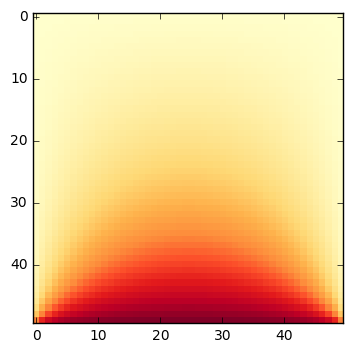

In [6]:
N = 50
T_SURR = 273
T_BOTT = 300

A = create_A(N)
C = create_C(N, T_SURR, T_BOTT)

T = np.dot(np.linalg.inv(A), C)
T_mat = np.reshape(T, (N,N))
plt.imshow(T_mat, cmap='YlOrRd', interpolation='nearest')

This shows the final temperature profile of this solid after it has reached steady state. Notice that the material being used never needed to be specified, as that only affects how quickly heat diffusion will occur. Also, notice how the bottom is much hotter than the other sides and how the heat has diffused evenly through.

# Two Dimensional Transient Heat Diffusion

We will now examine a 2D transient system with no internal generation. This gets rid of the z term, and the internal generation term. We will keep the time derivative term. Since we have second partial derivatives in space and a first partial derivative in time, in order to solve this system numerically we will need to discretize the system in space, and numerically integrate it with respect to time.

Here is the simplified heat diffusion equation:
$$ \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left( k \frac{\partial T}{\partial y} \right) = \rho c_p \frac{\partial T}{\partial t}$$

We can plug in the centered divided differences for the second derivatives in for the x and y components of this equation.

$$ \frac{T_{i+1, j} - 2 T_{i, j} + T_{i-1, j}}{\Delta x^2} + \frac{T_{i, j+1} - 2 T_{i, j} + T_{i, j-1}}{\Delta x^2} = \frac{\rho c_p}{k} \frac{\partial T}{\partial t} $$

We can solve it just how we solved the equation for the steady state response:

$$ T_{i+1, j} + T_{i-1, j} + T_{i, j+1} + T_{i, j-1} - 4 T{i, j} = \Delta x^2 \frac{\rho c_p}{k} \frac{\partial T}{\partial t} $$ 
$$ \frac{\partial T}{\partial t} = \frac{k}{\rho c_p \Delta x^2}\left( T_{i+1, j} + T_{i-1, j} + T_{i, j+1} + T_{i, j-1} - 4 T{i, j} \right)$$

This is the equation that we will use to describe the temperature profile at different times for this system.

<b> Exercise 3:</b> Write a function, create_surr(), that creates a grid of size n, creates a border around it at temperatures specified by the top, bottom, left, and right inputs. Set the rest of the piece to an initial temperature of T_init.

In [7]:
def create_surr(n, T_init, T_top, T_surr):
    ## This function takes in the size of the square piece and the surrounding temperatures (in Kelvin)
    ## It outputs a grid of zeros that have the correct surrounding temperatures
    grid = np.zeros((n+2, n+2))
    grid[:,0] = T_surr
    grid[:,-1] = T_surr
    grid[-1, :] = T_surr
    grid[0, :] = T_top
    grid[1:-1, 1:-1] = T_init
    return grid

<b> Exercise 4:</b> In order to solve this system we will discretize in space integrate numerically in time. First, we will write a function that describes the partial derivative $\frac{\partial T}{\partial t}$ in order for us to use it with odeint. Complete the function, f(), so that it returns $\frac{\partial T}{\partial t}$.

In [8]:
from scipy.integrate import odeint

In [9]:
def f(T, t0, Tsum, rho, cp, k, dx):
    return k/(rho*cp*dx)*(Tsum-4*T)

<b> Exercise 5:</b> Now you will need to complete this function that steps through every cell at every time and finds the next temperature at the next time. Implement this using odeint to integrate $\frac{\partial T}{\partial t}$

In [10]:
def step(grid_0, t_max, rho, cp, k, dx):
    grid = np.zeros((grid_0.shape[0], grid_0.shape[1], t_max))
    grid[:,:,0] = np.copy(grid_0)
    
    for t in range(t_max):
        grid[:,0] = grid_0[-1,-1]
        grid[:,-1] = grid_0[-1,-1]
        grid[-1, :] = grid_0[-1,-1]
        grid[0, :] = grid_0[0,0]

    tlist = np.arange(t_max)
    for t in range(1,t_max):
        for i in range(1,grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                #YOUR CODE HERE
                Tsum = grid[i-1, j, t-1] + grid[i, j-1, t-1] + grid[i+1, j, t-1] + grid[i, j+1, t-1]
                grid[i, j, t] =  odeint(f, grid[i,j,t-1], tlist, (Tsum, rho, cp, k, dx*dx))[t]
    return grid

Now we will simulate our system using the physical properties of steel. You can try playing around with the different properties to see what the different results are. For example, if you were to run this simulation with a plastic instead of a metal, you will find that much more time will be required to cool the solid down.

In [11]:
RHO_STEEL = 8050.0 #kg/m^3 
CP_STEEL = .49 #kJ/kg*K
K_STEEL = 43.0 # W/m*K
n = 20
dx = 1.0/n
T_surr = 250 #Kelvin
T_top = 250 #Kelvin
T_init = 350 #Kelvin
T_MAX = 50

grid_0 = create_surr(n, T_init, T_top, T_surr)
grid_t = step(grid_0, T_MAX, RHO_STEEL, CP_STEEL, K_STEEL, dx)

In [29]:
def display_heatmap(grid):
    img = plt.imshow(grid, cmap='YlOrRd', interpolation='nearest', vmin=250, vmax =350 )
    cbar = plt.colorbar(img)
    plt.show()

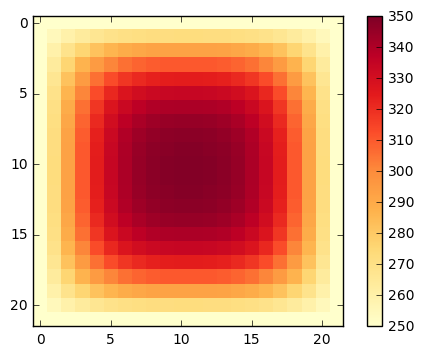

<function __main__.sim_grid_t>

In [30]:
from ipywidgets import interact

def sim_grid_t (t):
    grid_t[:,:,t]
    display_heatmap(grid_t[:,:,t])
    
interact (sim_grid_t
          , t=(0,T_MAX-1)
         )

This widget shows the change in the temperature profile at different times. The redder the pixel, the hotter and the more white, the cooler. The solid begins to cool rather quickly around the edges and then the rate of cooling slows down a lot. When analyzing the transient heat conduction of systems using differential equations instead of numerical methods, it is found that the temperature of the system reaches steady state logarithmically.

### Uneven temperature exposure
Now we will try to use our code to simulate a solid cooling in an environment with an uneven temperature distribution.

<b>Exercise 6:</b> Using the code that we have so far, simulate an unevenly cooled system with the top temperature lower than the rest of the surroundings.

In [31]:
T_surr = 325 #Kelvin
T_top = 250 #Kelvin
T_init = 350 #Kelvin

grid_0 = create_surr(n, T_init, T_top, T_surr)
grid_diff = step(grid_0, T_MAX, RHO_STEEL, CP_STEEL, K_STEEL, dx)

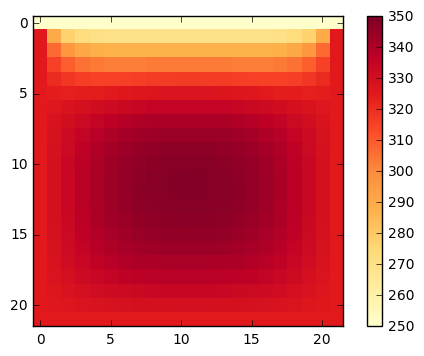

In [32]:
def sim_grid_diff (t):
    grid_diff[:,:,t]
    display_heatmap(grid_diff[:,:,t])
    
interact (sim_grid_diff
          , t=(0,T_MAX-1)
         )

When this reaches steady state, it should look pretty similar to the solid examined in part 1 of this simulation.

### Ideal Insulation
Now we will explore the benefits of an ideal insulator. In theory, an insulator should not allow the transfer of heat across this border. This means that when the temperature at the insulation is being calculated, the insulator should have no influence over the rate of change of the adjacent temperature. 

We will write a function that calculates the temperature of a solid when the top of the solid is insulated. 

<b> Exercise 7:</b> Write a function that will step through each time and find the temperature for the grid when there is insulation in the first row. Remember that the insulation means that no heat transfer will take place at this boundary.

In [16]:
def step_insulation_top(grid_0, t_max, rho, cp, dx):
    grid = np.zeros((grid_0.shape[0], grid_0.shape[1], t_max))
    grid[:,:,0] = np.copy(grid_0)
    
    for t in range(t_max):
        grid[:,0] = grid_0[-1,-1]
        grid[:,-1] = grid_0[-1,-1]
        grid[-1, :] = grid_0[-1,-1]
        grid[0, :] = grid_0[0,0]

    tlist = np.arange(t_max)
    for t in range(1,t_max):
        for i in range(1,grid.shape[0]-1):
            for j in range(1, grid.shape[1]-1):
                #YOUR CODE HERE
                if i==1:
                    Tsum = 2*grid[i, j-1, t-1] + 2*grid[i, j+1, t-1]
                else:
                    Tsum = grid[i-1, j, t-1] + grid[i, j-1, t-1] + grid[i+1, j, t-1] + grid[i, j+1, t-1]
                grid[i, j, t] =  odeint(f, grid[i,j,t-1], tlist, (Tsum, rho, cp, K_STEEL, dx*dx))[t]
    return grid

Now we will simulate the insulated system using a surrounding temperature of 300 K and an initial temperature of 350 K.

In [17]:
T_surr = 275 #Kelvin
T_init = 350 #Kelvin

grid_0 = create_surr(n, T_init, T_surr, T_surr)
grid_ins = step_insulation_top(grid_0, T_MAX, RHO_STEEL, CP_STEEL, dx)

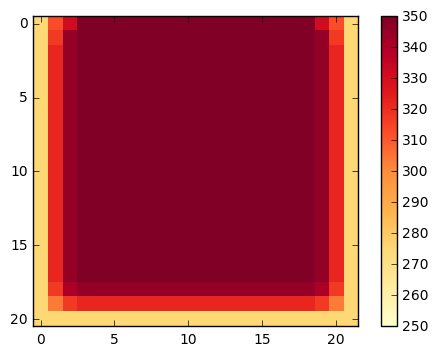

In [33]:
def sim_grid_ins (t):
    grid_ins[:,:,t]
    display_heatmap(grid_ins[1:,:,t])
    
interact (sim_grid_ins
          , t=(0,T_MAX-1)
         )

Notice how the top of the block, which is insulated, cools at a slower rate than the rest of the block.

### Heat Transfer Through Irregular Shapes
In the real world, perfectly shaped rectangles will rarely ever be dealt with. We will now investigate the heat transfer through irregular shapes. An extremely common shape in engineering is an I beam. 

In [19]:
def is_base(t, row):
    if row <= t or row >= h-t:
        return True
    return False

def is_column(t,row):
    if row > t and row < h-t:
        return True
    return False

In [20]:
def create_I_cross_sect(b, h, t, T_init, T_surr):
    ## This function takes in the size of the square piece and the surrounding temperatures (in Kelvin)
    ## It outputs a grid of zeros that have the correct surrounding temperatures
    grid = np.zeros((h+1, b+2))
#     grid[:,0] = T_surr
#     grid[:,-1] = T_surr
    grid[-1, :] = T_surr
    grid[0, :] = T_top
    mid = int(b/2)
    for row in range(1,h):
        if is_base(t,row):
            grid[row, 1:-1] = T_init
            grid[row, 0] = T_surr
            grid[row, -1] = T_surr
        elif is_column(t,row):
            grid[row, mid-t:mid+t] = T_init
            grid[row, mid-t] = T_surr
            grid[row, mid+t] = T_surr
#             if row == t+1 or row == h-t-1:
            grid[row, 0:mid-t] = T_surr
            grid[row, mid+t+1:] = T_surr
    return grid

In [21]:
T_init = 350 
T_top = 250 
T_surr = 250 
b = 30
h = 40
thickness = 4
I_grid = create_I_cross_sect(b, h, thickness, T_init, T_surr)

In [22]:
def step_I(grid_0, t_max, rho, cp, dx, thick, b, h):
    grid = np.zeros((grid_0.shape[0], grid_0.shape[1], t_max))
    
    for i in range(t_max):
        grid[:,:,i] = np.copy(grid_0)
    
    mid = int(b/2)

    tlist = np.arange(t_max)
    for t in range(1,t_max):
        for i in range(1,grid.shape[0]-1):
            
            if is_base(thick, i):
                for j in range(1, grid.shape[1]-1):
                    Tsum = grid[i-1, j, t-1] + grid[i, j-1, t-1] + grid[i+1, j, t-1] + grid[i, j+1, t-1]
                    grid[i, j, t] =  odeint(f, grid[i,j,t-1], tlist, (Tsum, rho, cp, K_STEEL, dx*dx))[t]
        
            elif is_column(thick,i):
                for j in range(mid-thick, mid+thick+1):
                    if j==1:
                        Tsum = 2*grid[i, j-1, t-1] + 2*grid[i, j+1, t-1]
                    else:
                        Tsum = grid[i-1, j, t-1] + grid[i, j-1, t-1] + grid[i+1, j, t-1] + grid[i, j+1, t-1]
                    grid[i, j, t] =  odeint(f, grid[i,j,t-1], tlist, (Tsum, rho, cp, K_STEEL, dx*dx))[t]
    return grid

In [23]:
grid_I_t = step_I(I_grid, T_MAX, RHO_STEEL, CP_STEEL, dx, thickness, b, h)

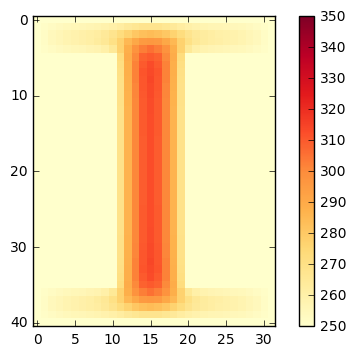

<function __main__.sim_grid_I>

In [34]:
def sim_grid_I (t):
    grid_I_t[:,:,t]
    display_heatmap(grid_I_t[:,:,t])
    
interact (sim_grid_I
          , t=(0,T_MAX-1)
         )